In [52]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multidist_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle

In [53]:
# loading notes csv
notes = pd.read_csv('notes.csv')

In [54]:
notes

,Sno,Laser dist,Tape dist
0,0,30.8,30
1,1,70.3,70
2,2,110.5,110
3,3,150.4,150
4,4,189.8,190


In [55]:
print(float(notes[notes['Sno']==0]['Laser dist'].iloc[0]))
print(float(notes[notes['Sno']==0]['Tape dist'].iloc[0]))


30.8
30.0


In [56]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    laser_dist=float(notes[notes['Sno']==dist_idx]['Laser dist'].iloc[0])
    tape_dist=float(notes[notes['Sno']==dist_idx]['Tape dist'].iloc[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        # Add new columns to _df for all rows
        _df['Run Exp Num'] = dist_idx
        _df['Laser dist'] = laser_dist/100
        _df['Tape dist'] = tape_dist/100
        if df_all is None:
            df_all=_df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)

df_all

0.df
1.df
2.df
3.df
4.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs,Laser dist,Tape dist
0,Tag1,Tag2,1.756672e+09,1.756672e+09,"[105.78, 93.96, 94.19, 94.03, 94.19, 93.88, 93...",775,0,5,0.308,0.3
1,Tag2,Tag1,1.756672e+09,1.756672e+09,"[177.5, 90.52, 90.83, 90.98, 90.6, 90.75, 90.8...",775,0,5,0.308,0.3
2,Tag1,Tag2,1.756672e+09,1.756672e+09,"[95.94, 193.68, 193.75, 194.13, 193.6, 194.21,...",785,0,5,0.308,0.3
3,Tag2,Tag1,1.756672e+09,1.756672e+09,"[85.11, 188.94, 189.71, 189.56, 189.78, 189.33...",785,0,5,0.308,0.3
4,Tag1,Tag2,1.756672e+09,1.756672e+09,"[197.11, 262.04, 262.72, 262.8, 262.72, 263.03...",795,0,5,0.308,0.3
...,...,...,...,...,...,...,...,...,...,...
225,Tag2,Tag1,1.756676e+09,1.756676e+09,"[33.07, 20.1, 19.65, 19.8, 19.8, 19.65, 19.72,...",975,4,5,1.898,1.9
226,Tag1,Tag2,1.756676e+09,1.756676e+09,"[1.18, 0.72, 0.72, 0.72, 0.65, 0.8, 0.65, 1.11...",985,4,5,1.898,1.9
227,Tag2,Tag1,1.756676e+09,1.756676e+09,"[19.65, 8.96, 9.12, 9.42, 9.12, 9.04, 9.12, 9....",985,4,5,1.898,1.9
228,Tag1,Tag2,1.756676e+09,1.756676e+09,"[0.95, 0.72, 0.65, 0.65, 0.65, 0.65, 0.72, 0.6...",995,4,5,1.898,1.9


In [57]:
df_all.to_csv('del.csv')

In [58]:
time_per_phase = 10/1000  # s
num_phases=6
num_mpps=df_all.iloc[0]['NumMPPs']
sampling_rate=1000
plotting=False
ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
                                "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])

if plotting:
    plt.figure(figsize=(15,20))

unique_exp_no=0
phase_order=[1,3,4,6,7,8]

for df_idx in range(len(df_all)):

    voltages=df_all.iloc[df_idx]['Voltages (mV)']
    phase_medians={
        1:[],
        3:[],
        4:[],
        6:[],
        7:[],
        8:[],
    }
    for idx,v in enumerate(ver_lines):
        if idx<len(ver_lines)-1:
            phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
        if plotting:
            plt.subplot(len(df_all)//3+1, 3, df_idx+1)
            if idx%num_phases==0:
                plt.axvline(x=v, color='b', linestyle='-')
            else:
                plt.axvline(x=v, color='r', linestyle='--')
    entry={
        "Rx": df_all.iloc[df_idx]["Rx"],
        "Tx":df_all.iloc[df_idx]["Tx"],
        "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
        "Phase1":phase_medians[1],
        "Phase3":phase_medians[3],
        "Phase4":phase_medians[4],
        "Phase6":phase_medians[6],
        "Phase7":phase_medians[7],
        "Phase8":phase_medians[8],
        "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
        "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
        "Tape Dist (m)":df_all.iloc[df_idx]["Tape dist"],
        "Laser Dist (m)":df_all.iloc[df_idx]["Laser dist"],
        "Dist (m)":df_all.iloc[df_idx]["Laser dist"],
        "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
    }
    for phase in phase_order:
        entry_aggregated={
            "Rx":df_all.iloc[df_idx]["Rx"],
            "Tx":df_all.iloc[df_idx]["Tx"],
            "phase": str(phase),
            "median": np.mean(phase_medians[phase]), # mean of medians
            "std": np.std(phase_medians[phase]),
            "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
            "dist":df_all.iloc[df_idx]["Laser dist"],
            'delta': max(phase_medians[phase])-min(phase_medians[phase]),
            "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
            "Unique Exp Number":unique_exp_no,
            "allVoltages": phase_medians[phase]
        }
        processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
    unique_exp_no+=1
    
    # Identify and print bad MPPs
    bad=False
    for k in phase_medians.keys():
        assert(len(phase_medians[k])==num_mpps)
        if np.std(phase_medians[k])>1:
            print(f"<== Bad data found at {df_idx} df_idx at phase {k}.", end="\t")
            print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
    
    processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    if plotting:
        plt.plot(voltages,'.')
        plt.title(df_idx)
        plt.tight_layout()
        
if plotting:
    plt.show()
    
    

/var/folders/hm/7p8fzz2x2y10pbydpxcs7vw00000gn/T/ipykernel_98058/2011979895.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)


In [59]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs,Tape Dist (m),Laser Dist (m),Dist (m)
0,Tag1,Tag2,"[105.78, 93.96, 94.19, 94.03, 94.19, 93.88, 93...","[93.96, 93.96, 93.96, 94.11, 93.995]","[91.29, 91.52, 91.325, 91.13499999999999, 91.095]","[88.53999999999999, 88.81, 88.92, 88.77, 88.655]","[112.27, 112.27, 112.345, 112.27, 112.27]","[104.64, 104.87, 104.755, 104.56, 104.68]","[95.86, 96.21000000000001, 95.9, 96.13, 96.13]",775,0,5,0.3,0.308,0.308
1,Tag2,Tag1,"[177.5, 90.52, 90.83, 90.98, 90.6, 90.75, 90.8...","[90.83, 91.02000000000001, 90.87, 91.13, 90.83]","[90.065, 90.10499999999999, 89.875, 90.18, 90.03]","[92.85, 92.89, 92.97, 93.04, 92.89]","[94.19, 93.995, 93.8, 94.07, 93.995]","[89.305, 89.15, 89.3, 89.38, 89.035]","[85.72, 85.72, 85.49, 85.68, 85.64]",775,0,5,0.3,0.308,0.308
2,Tag1,Tag2,"[95.94, 193.68, 193.75, 194.13, 193.6, 194.21,...","[193.75, 193.79000000000002, 194.055, 193.8299...","[189.20999999999998, 189.44, 189.5199999999999...","[190.965, 191.04000000000002, 190.93, 191.0, 1...","[229.38, 229.38, 229.76, 229.725, 229.495]","[214.81, 214.43, 214.465, 214.425, 214.315]","[197.72, 197.45499999999998, 197.45, 197.605, ...",785,0,5,0.3,0.308,0.308
3,Tag2,Tag1,"[85.11, 188.94, 189.71, 189.56, 189.78, 189.33...","[189.4, 189.325, 188.865, 189.445, 188.94]","[188.45, 187.95, 187.88, 188.145, 188.10500000...","[191.62, 191.92, 191.62, 191.62, 191.579999999...","[190.28, 190.13, 189.935, 190.09, 190.015]","[178.38, 178.26, 178.19, 178.49, 178.415000000...","[182.115, 182.0, 181.85, 182.15, 181.965]",785,0,5,0.3,0.308,0.308
4,Tag1,Tag2,"[197.11, 262.04, 262.72, 262.8, 262.72, 263.03...","[262.8, 263.03, 262.8, 263.22, 263.025]","[264.36, 264.63, 264.44, 264.66999999999996, 2...","[291.525, 291.37, 291.26, 291.71, 291.64]","[292.82, 292.59, 292.93499999999995, 292.9, 29...","[276.41999999999996, 276.46, 276.15, 276.41999...","[263.94, 264.21000000000004, 264.245, 263.98, ...",795,0,5,0.3,0.308,0.308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,Tag2,Tag1,"[33.07, 20.1, 19.65, 19.8, 19.8, 19.65, 19.72,...","[19.72, 19.57, 19.65, 19.65, 19.61]","[19.685, 19.645, 19.685, 19.57, 19.65]","[19.835, 19.8, 19.72, 19.8, 19.72]","[19.8, 19.72, 19.759999999999998, 19.835, 19.72]","[19.72, 19.8, 19.685, 19.72, 19.759999999999998]","[19.685, 19.65, 19.72, 19.65, 19.759999999999998]",975,4,5,1.9,1.898,1.898
226,Tag1,Tag2,"[1.18, 0.72, 0.72, 0.72, 0.65, 0.8, 0.65, 1.11...","[0.72, 1.11, 1.03, 1.03, 1.11]","[1.11, 1.03, 1.03, 1.11, 1.11]","[1.07, 1.18, 1.03, 1.11, 1.03]","[1.11, 1.07, 1.03, 1.03, 1.22]","[1.07, 1.11, 1.11, 1.03, 1.18]","[1.03, 1.11, 1.11, 1.03, 1.07]",985,4,5,1.9,1.898,1.898
227,Tag2,Tag1,"[19.65, 8.96, 9.12, 9.42, 9.12, 9.04, 9.12, 9....","[9.12, 9.04, 9.04, 9.079999999999998, 9.0]","[8.96, 8.96, 8.89, 8.96, 8.89]","[9.079999999999998, 9.04, 9.12, 9.12, 9.04]","[9.04, 9.04, 9.12, 9.04, 9.04]","[9.04, 8.96, 9.04, 9.04, 9.04]","[9.04, 9.0, 9.04, 9.079999999999998, 9.04]",985,4,5,1.9,1.898,1.898
228,Tag1,Tag2,"[0.95, 0.72, 0.65, 0.65, 0.65, 0.65, 0.72, 0.6...","[0.65, 1.18, 1.11, 1.11, 1.11]","[1.11, 1.11, 1.18, 1.11, 1.11]","[1.18, 1.145, 1.18, 1.18, 1.18]","[1.145, 1.11, 1.18, 1.11, 1.11]","[1.11, 1.11, 1.145, 1.18, 1.145]","[1.11, 1.11, 1.18, 1.18, 1.07]",995,4,5,1.9,1.898,1.898


In [60]:
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
0,Tag1,Tag2,1,93.997,0.058103,775000000.0,0.308,0.150,0,0,"[93.96, 93.96, 93.96, 94.11, 93.995]"
1,Tag1,Tag2,3,91.273,0.151479,775000000.0,0.308,0.425,0,0,"[91.29, 91.52, 91.325, 91.13499999999999, 91.095]"
2,Tag1,Tag2,4,88.739,0.130706,775000000.0,0.308,0.380,0,0,"[88.53999999999999, 88.81, 88.92, 88.77, 88.655]"
3,Tag1,Tag2,6,112.285,0.030000,775000000.0,0.308,0.075,0,0,"[112.27, 112.27, 112.345, 112.27, 112.27]"
4,Tag1,Tag2,7,104.701,0.105376,775000000.0,0.308,0.310,0,0,"[104.64, 104.87, 104.755, 104.56, 104.68]"
...,...,...,...,...,...,...,...,...,...,...,...
1375,Tag2,Tag1,3,5.784,0.032000,995000000.0,1.898,0.080,4,229,"[5.8, 5.76, 5.76, 5.76, 5.84]"
1376,Tag2,Tag1,4,5.903,0.014000,995000000.0,1.898,0.035,4,229,"[5.91, 5.91, 5.91, 5.91, 5.875]"
1377,Tag2,Tag1,6,5.927,0.053254,995000000.0,1.898,0.155,4,229,"[5.91, 5.91, 5.875, 6.03, 5.91]"
1378,Tag2,Tag1,7,5.896,0.028000,995000000.0,1.898,0.070,4,229,"[5.84, 5.91, 5.91, 5.91, 5.91]"


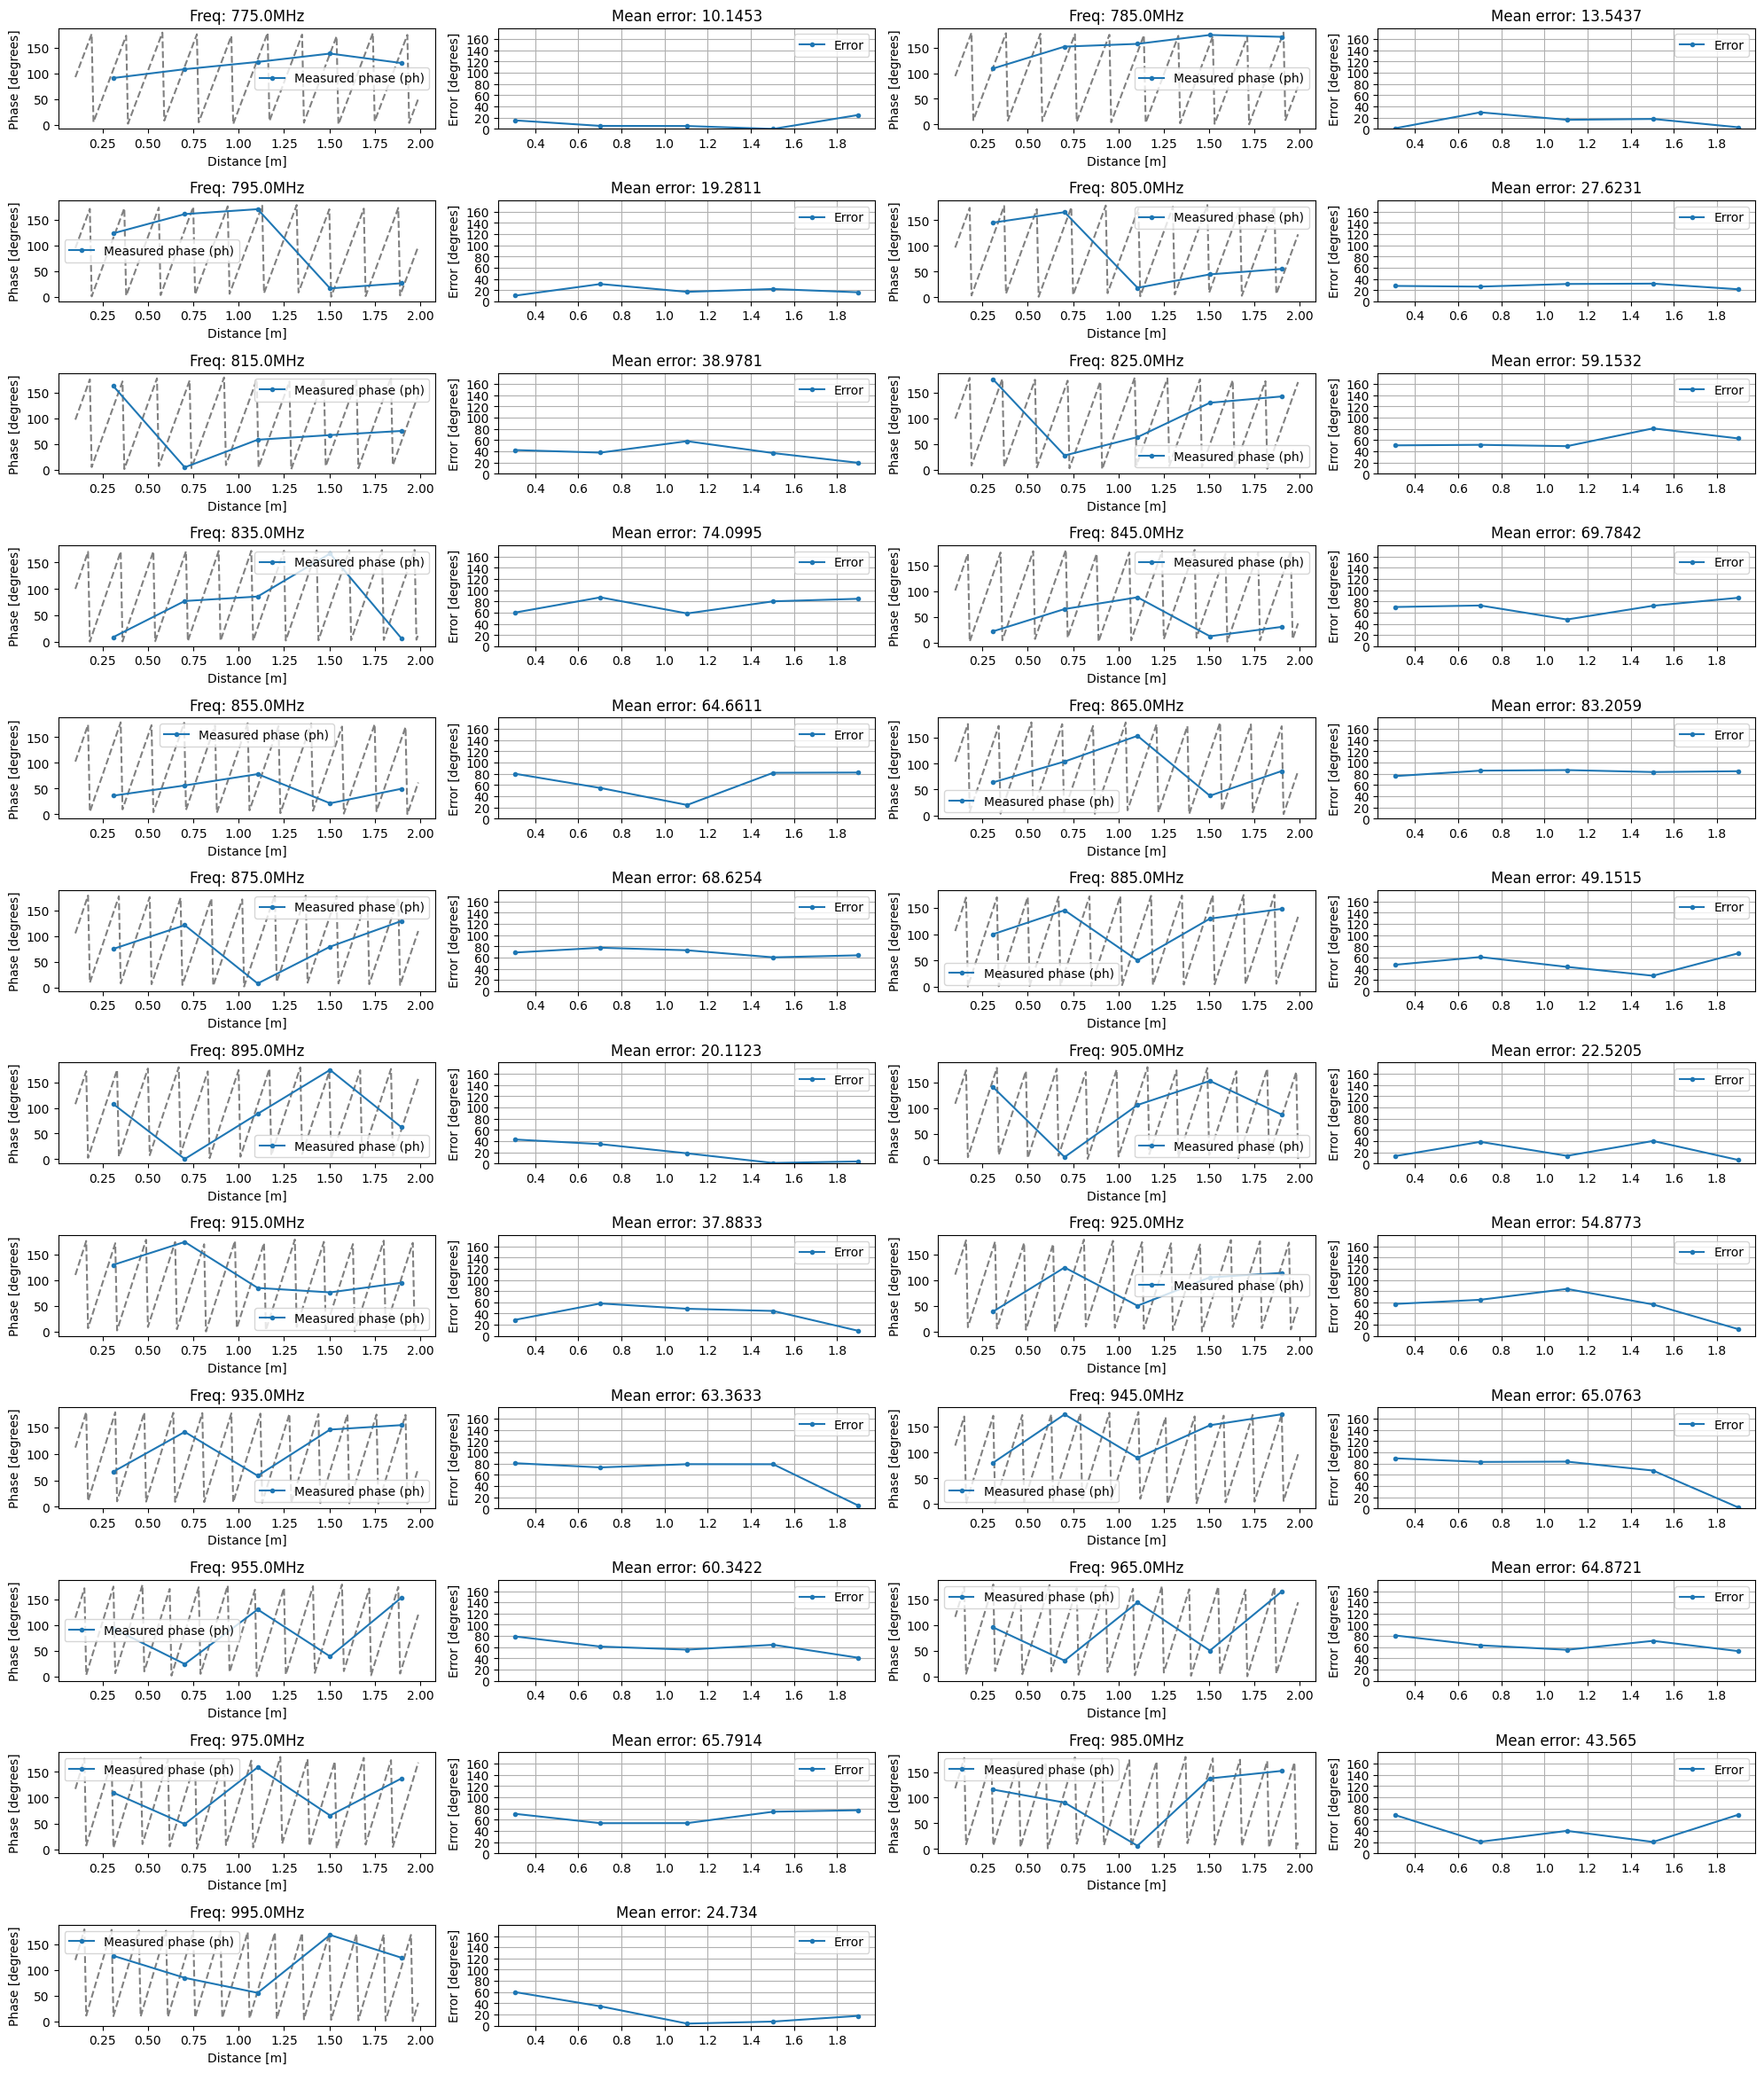

In [61]:
freq_range=np.array(range(775,1000,10))*1e6
all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors, \
    selected_experiments_all = multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=True)

with open("no_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)

with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)

with open("theoretical_phase.pkl",'wb') as f:
    pickle.dump(all_freqs_theoretical,f) 

### With offset correction using the ground truth.

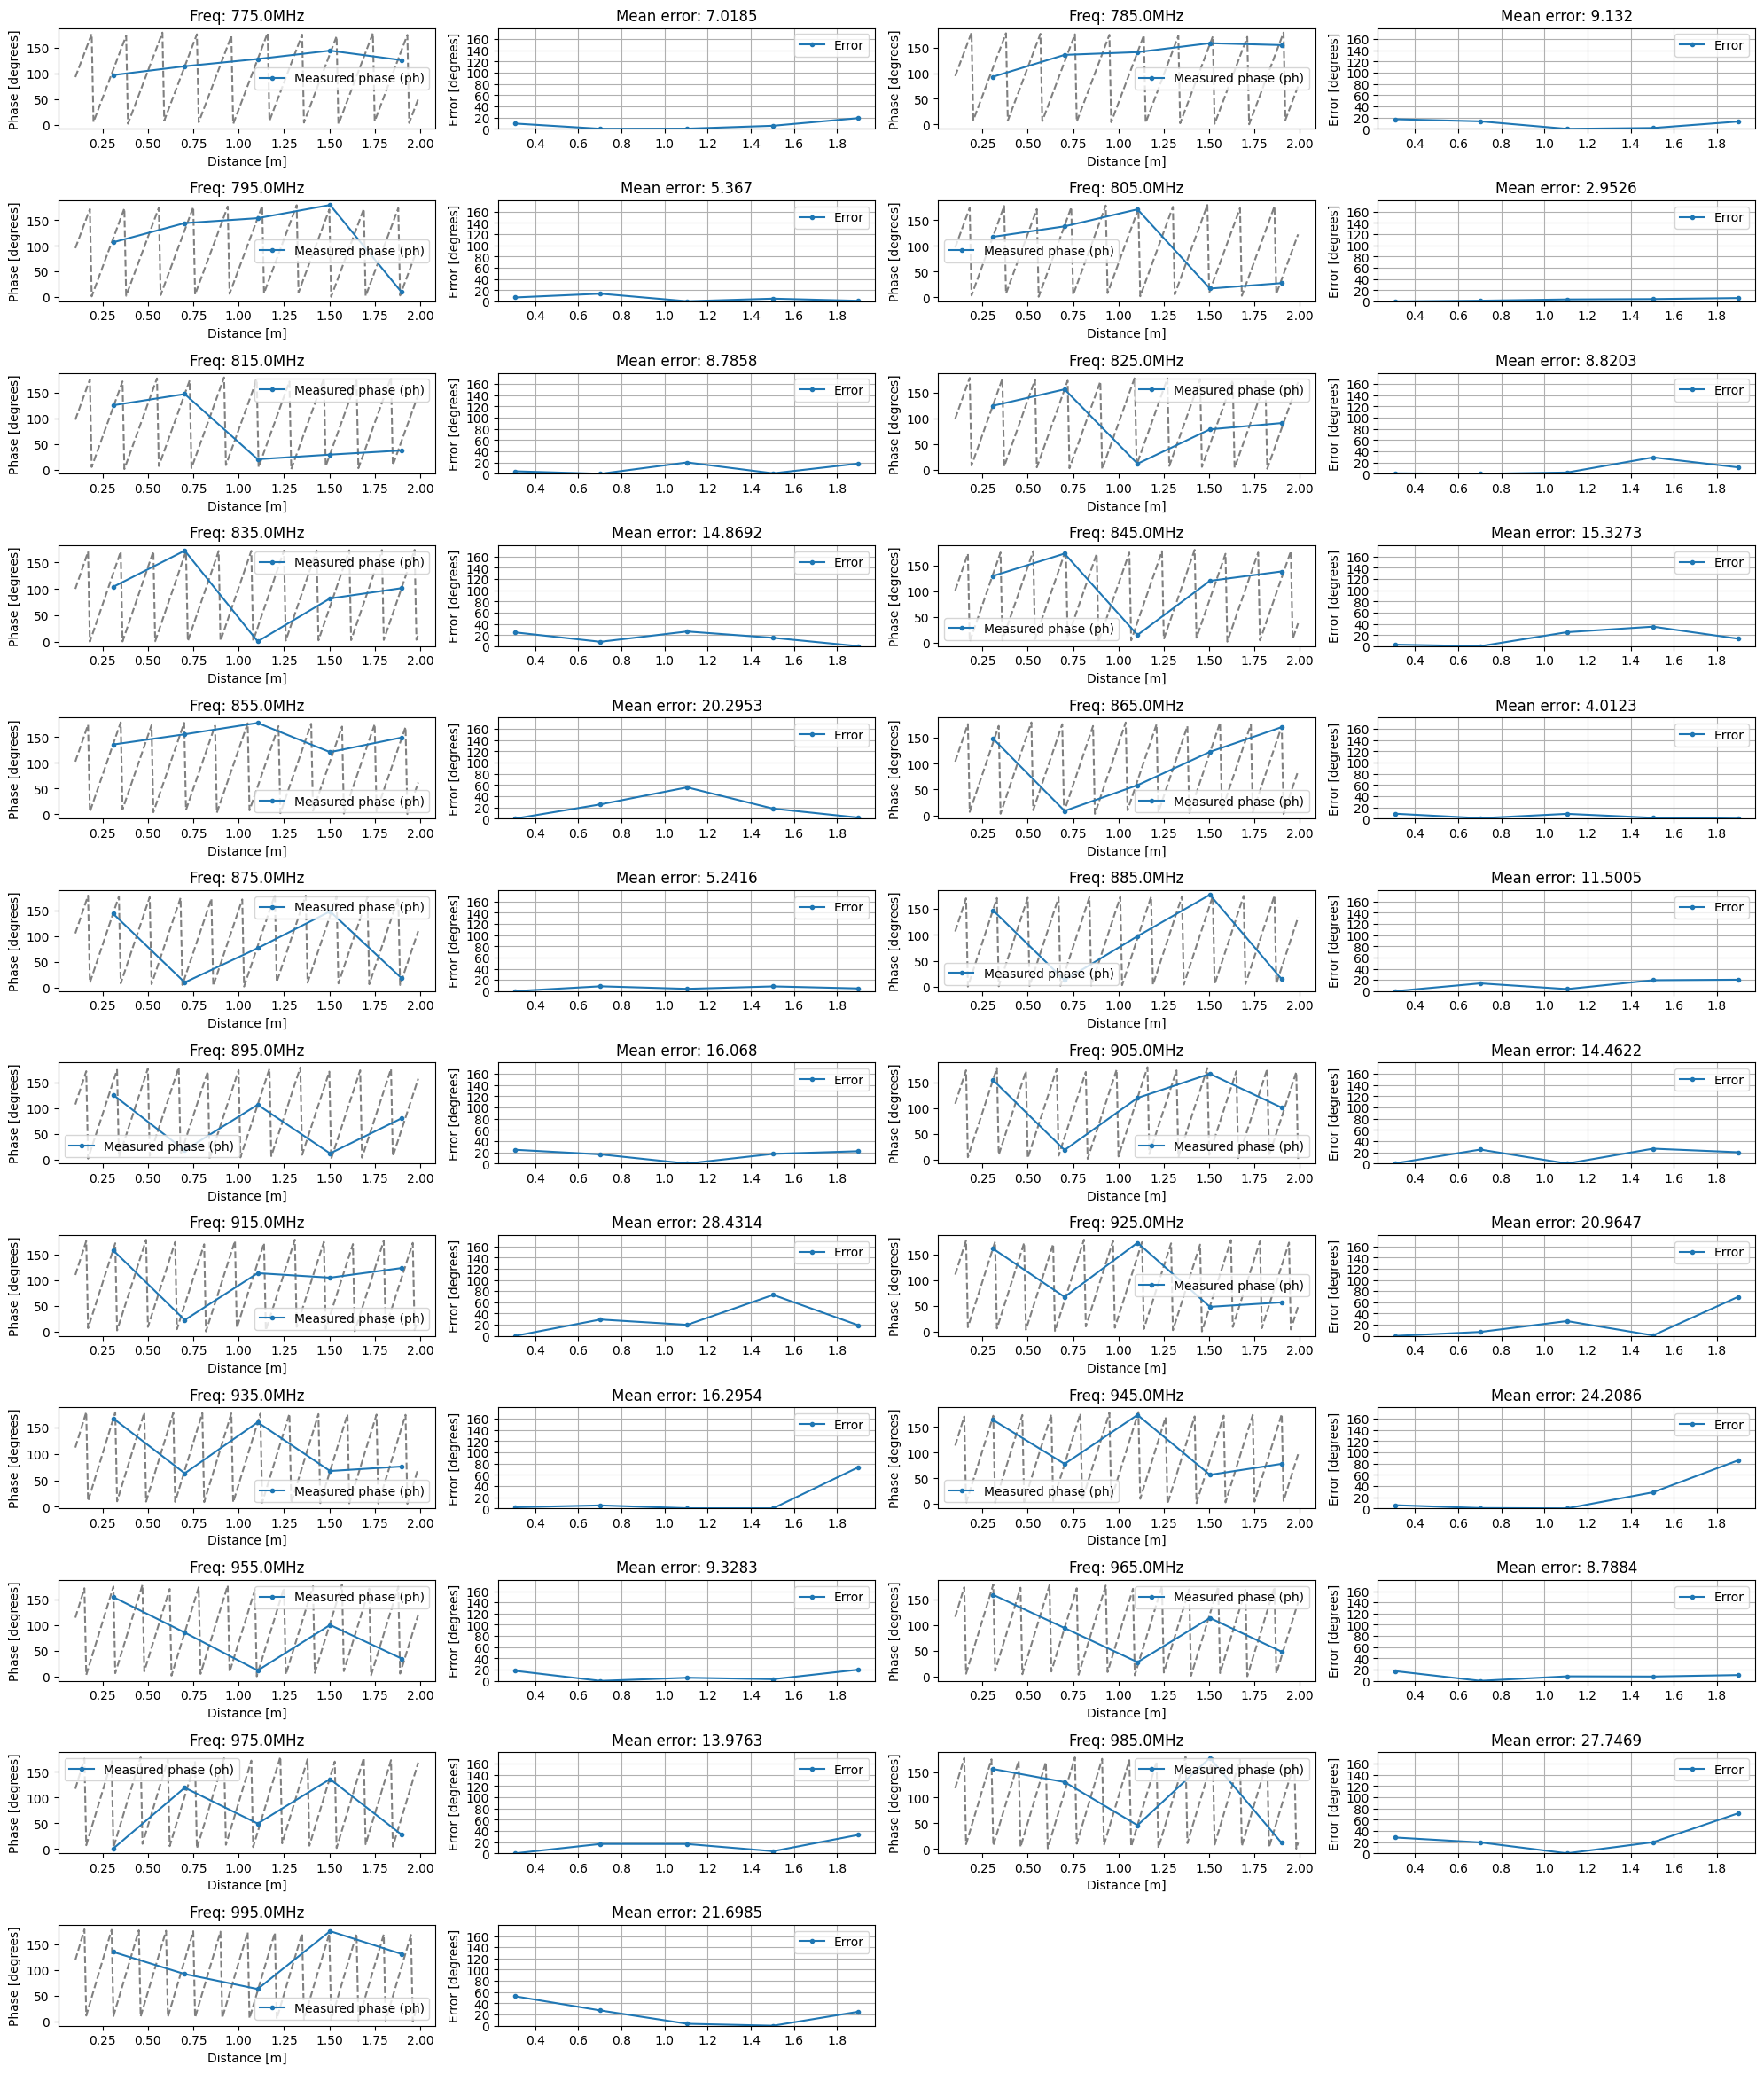

In [62]:
correction_offsets={}
all_errors=None


all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, _,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False)


for freq in freq_range:
    offset,best_error,errors=get_offset(all_freqs[freq],freq)
    # print(f"Freq {freq//1e6};\t Mean:{np.mean(errors)};\t Median:{np.median(errors)};\t Std:{np.std(errors)}")
    # if all_errors is None:
    #     all_errors=errors
    # else:
    #     all_errors=np.concat((all_errors,errors))
    correction_offsets[freq]=offset



all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


with open("gt_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("gt_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("gt_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)    

### With correction offsets from pretrained

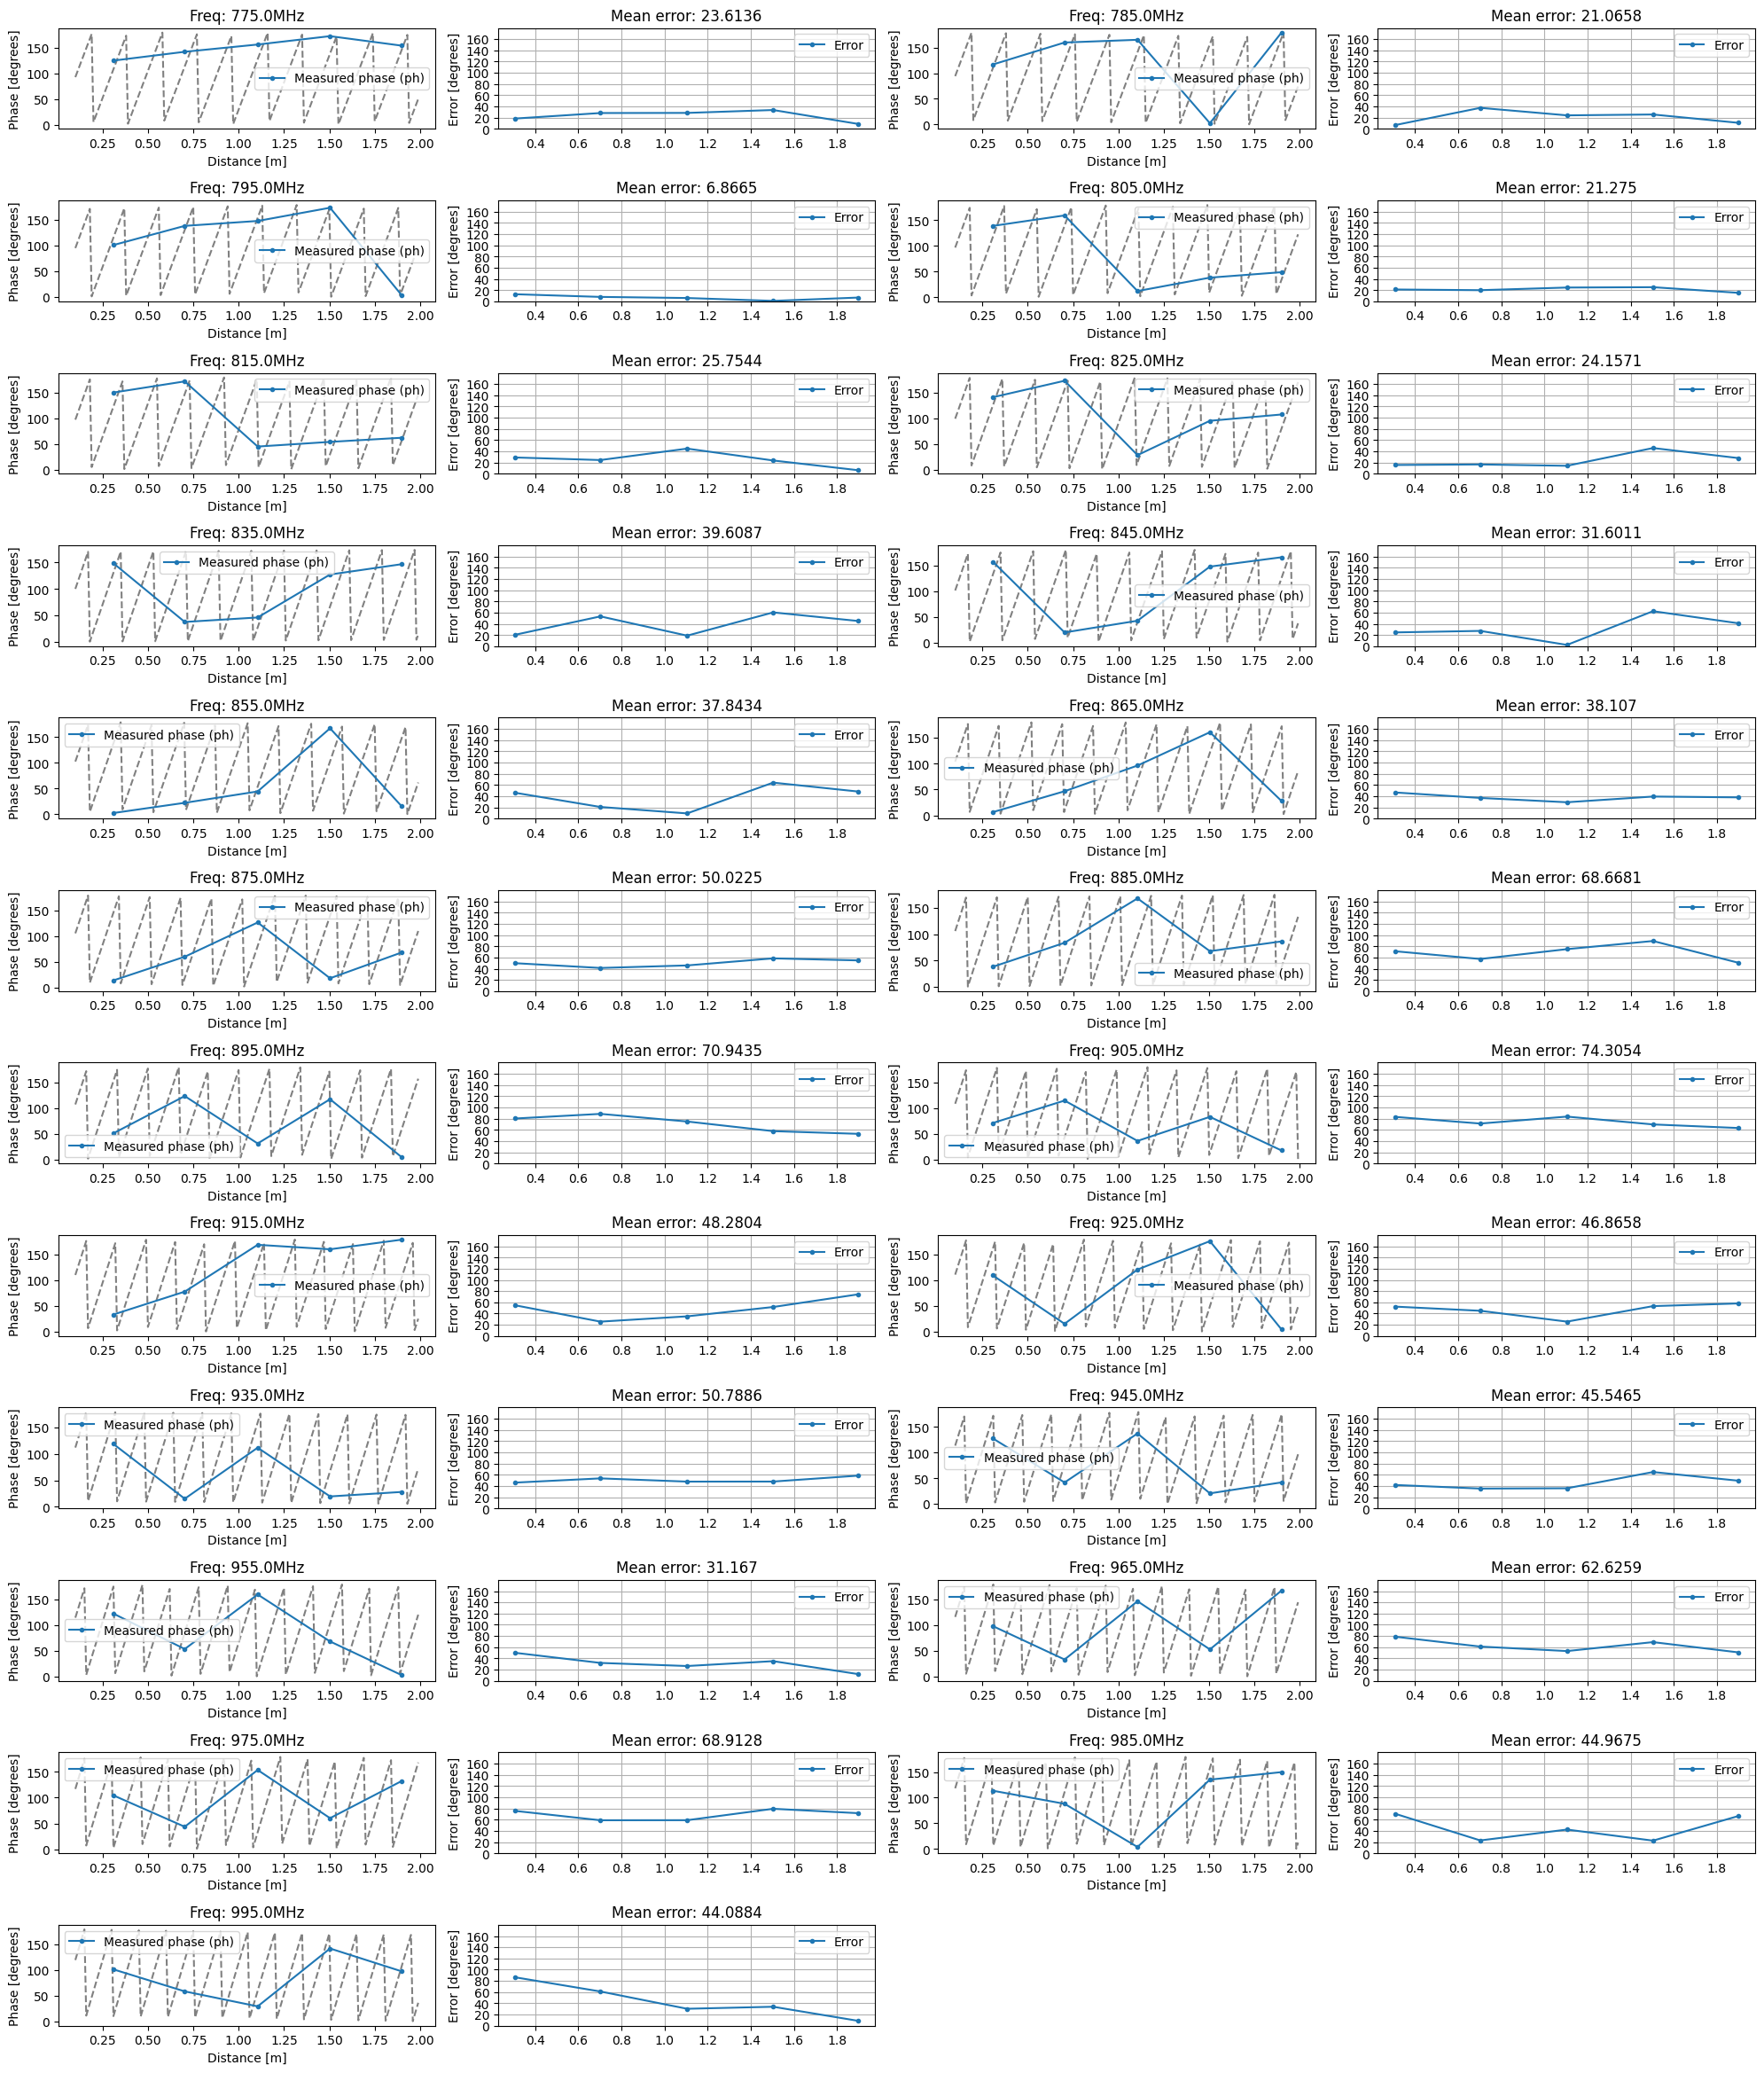

In [63]:
correction_offsets=pickle.load(open("/Users/manavjeet/git/T2TExperiments/DistExperiments/correction_offsets.pkl",'rb'))

all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


with open("pretrained_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("pretrained_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("pretrained_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)